# Subreddit Stats

In [180]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as md
import numpy as np
import praw
from psaw import PushshiftAPI
import datetime
import yaml
import time
from sortedcontainers import SortedDict
from collections import OrderedDict
import os.path
import pickle
import re
from IPython.display import HTML

In [2]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [3]:
# Parameters

start_epoch = int(datetime.datetime(2019, 1, 1).timestamp())
start_subs = 659       # number of subs at start_epoch (needed if before 2018/3/15, see redditmetrics.com)
#end_epoch = int(datetime.datetime(2019, 1, 1).timestamp())
end_epoch = int(time.time())
max_posts = None      # max number of posts to crawl, None for unlimited
sub = 'dreamcatcher'   # subreddit to crawl
num_score_calls = 5   # number of times to query score to mitigate reddit's score fuzzing
                       #     note: will drastically increase data acquisition time
cache_file = 'cache.pkl'    # cache file
skip_cache_days = 400 # skip cache for posts younger than this
secs_in_day = 86400

## Get Data

In [4]:
class Comment:
    def __init__(self):
        self.id = ''
        self.body = ''
        self.author = ''
        self.score = 0
        self.ts = 0
        self.url = ''
        self.score_arr = np.zeros((num_score_calls))

class Post:
    def __init__(self):
        self.id = ''
        self.title = ''
        self.author = ''
        self.ts = 0
        self.score = 0
        self.comments = []
        self.url = ''
        self.score_arr = np.zeros((num_score_calls))

In [5]:
def getSubComments(comment, allComments, verbose=True):
    allComments.append(comment)
    if not hasattr(comment, "replies"):
        replies = comment.comments()
    if verbose:
        print("fetching (" + str(len(allComments)) + " comments fetched total)")
    else:
        replies = comment.replies
    for child in replies:
        getSubComments(child, allComments, verbose=verbose)


def getAll(r, submissionId, verbose=True):
    submission = r.submission(submissionId)
    submission.comments.replace_more(limit=None)
    comments = submission.comments
    commentsList = []
    for comment in comments:
        getSubComments(comment, commentsList, verbose=verbose)
    return commentsList

def save_obj(name, obj):
    with open(name, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name, 'rb') as f:
        return pickle.load(f)

In [6]:
stream = open('client_info.txt', 'r')
doc = yaml.load(stream)

r = praw.Reddit(client_id=doc['client_id'],
                client_secret=doc['client_secret'],
                user_agent='test'
                )
api_ps_praw = PushshiftAPI(r)
api_ps = PushshiftAPI()
post_ids = api_ps_praw.search_submissions(after=start_epoch,
                                  before=end_epoch,
                                  subreddit=sub,
                                  filter=['url', 'author', 'title', 'subreddit'],
                                  limit=max_posts)
subs = api_ps.search_submissions(after=start_epoch,
                                  before=end_epoch,
                                  subreddit=sub,
                                  filter=['subreddit', 'id', 'subreddit_subscribers'],
                                  limit=max_posts)
id2subs = {}

for s in subs:
    if hasattr(s, 'subreddit_subscribers'):
        num_subs = s.subreddit_subscribers
    else:
        num_subs = -1    
    id2subs[s.id] = num_subs
            
if os.path.isfile(cache_file):
    posts, subcount_temp = load_obj(cache_file)
    print('cache found')
else:
    posts = OrderedDict()
    subcount_temp = SortedDict()
prev_info_len = 1
temp_score_arr = np.zeros((num_score_calls))
print('fetching data...')
for i, post_id in enumerate(post_ids):
    if post_id.id not in posts or \
            posts[post_id.id].ts + skip_cache_days*secs_in_day > time.time():
        submission = praw.models.Submission(r, id=post_id)
        ts = int(submission.created_utc)
        ts_str = datetime.datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')
        subcount_temp[ts] = id2subs[post_id.id]

        c_temp = getAll(r, post_id, verbose=False)
        c = [Comment() for _ in range(len(c_temp))]

        for k, comment in enumerate(c_temp):
            c[k].body = comment.body
            c[k].author = comment.author
            c[k].ts = comment.created_utc
            c[k].score = comment.score
            c[k].permalink = comment.permalink
            c[k].id = comment.id
            c[k].distinguished = comment.distinguished
            c[k].gilded = comment.gilded
            c[k].gildings = comment.gildings
            try:
                c[k].flair = comment.author_flair_text
            except AttributeError:
                c[k].flair = None
            try:
                c[k].flair_template = comment.author_flair_template_id
            except AttributeError:
                c[k].flair_template = None
            c[k].score_arr[0] = comment.score

        for j in range(1, num_score_calls):
            c_temp = getAll(r, post_id, verbose=False)
            for k, comment in enumerate(c_temp):
                c[k].score_arr[j] = comment.score

        temp = Post()
        temp.id = submission.id
        temp.title = submission.title
        temp.author = submission.author
        temp.ts = submission.created_utc
        temp.comments = c
        temp.permalink = submission.permalink
        temp.is_self = submission.is_self
        temp.selftext = submission.selftext
        temp.url = submission.url
        temp.distinguished = submission.distinguished
        temp.gilded = submission.gilded
        temp.gildings = submission.gildings
        
        try:
            temp.link_flair = submission.link_flair_text
        except AttributeError:
            temp.link_flair = None
        try:
            temp.author_flair = submission.author_flair_text
        except AttributeError:
            temp.author_flair = None
        try:
            temp.link_flair_template = submission.link_flair_template_id
        except AttributeError:
            temp.link_flair_template = None
        try:
            temp.author_flair_template = submission.author_flair_template_id
        except AttributeError:
            temp.author_flair_template = None

        for j in range(num_score_calls):
            submission = praw.models.Submission(r, id=post_id)
            temp.score_arr[j] = submission.score
        posts[temp.id] = temp
        save_obj(cache_file, [posts, subcount_temp])
    else:
        ts = int(posts[post_id.id].ts)
        ts_str = datetime.datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')
    
    title = (posts[post_id.id].title[:47] + '...') if len(posts[post_id.id].title) > 47 else posts[post_id.id].title
    info = '%08d: %s --- %s' % (i, ts_str, title)
    clear = ' ' * prev_info_len
    print('%s' % clear, end='\r', flush=True)
    prev_info_len = len(info)
    print('%s' % info, end='\r', flush=True)

    
for key, post in posts.items():
    post.score = np.median(post.score_arr) - 1
    for comment in post.comments:
        comment.score = np.median(comment.score_arr) - 1
    
print('\ndone')

<ipython-input-6-6c69f3cd0290>:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  doc = yaml.load(stream)
/home/evan/subreddit_stats/subreddit_stats_venv/lib/python3.8/site-packages/psaw/PushshiftAPI.py:153: UserWarning: Unable to connect to pushshift.io. Retrying after backoff.
  warnings.warn("Unable to connect to pushshift.io. Retrying after backoff.")


cache found
fetching data...
00006957: 2019-01-01 06:56:47 --- Dreamcatcher ft. LEEZ - Lullaby                   .....
done


## Visualize Data

### Subscriber Growth

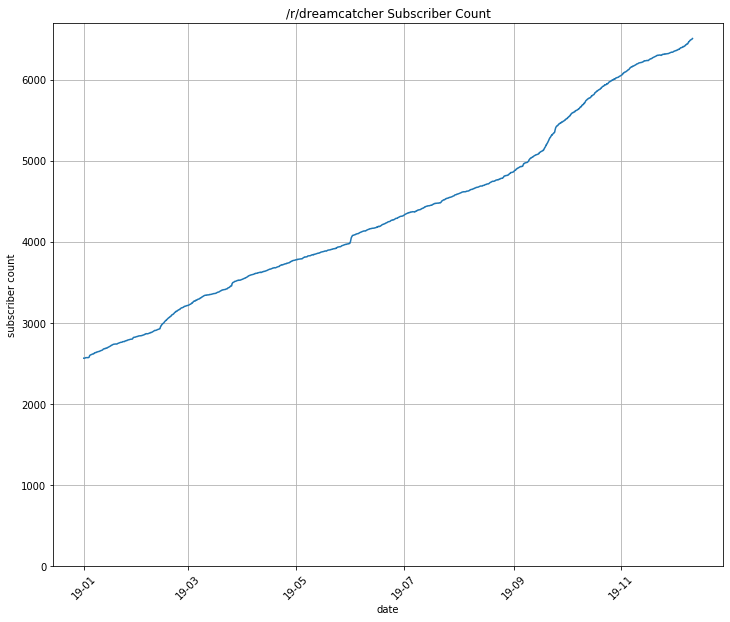

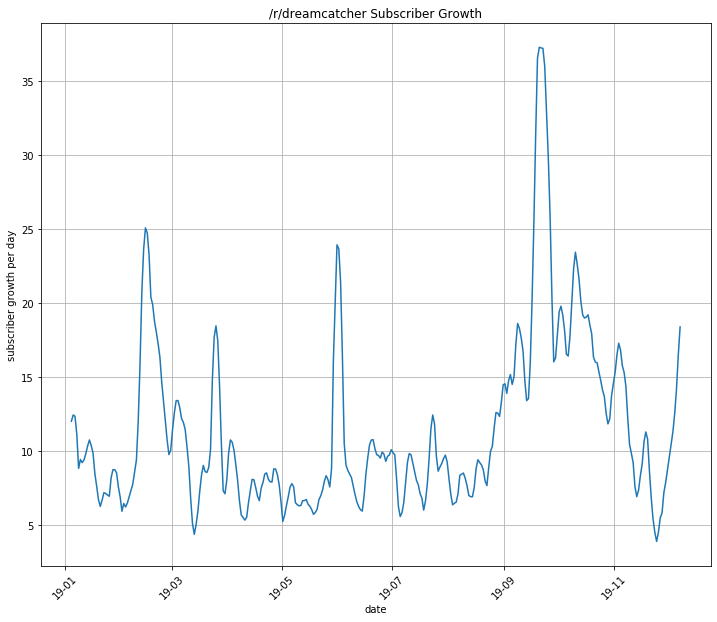

In [8]:
kernel_size = 7

# fix (interpolate) bad sub count data
timestamps = np.zeros(len(subcount_temp))
subs = np.zeros(len(subcount_temp))
no_sub_data_end = -1
temp = 0
for i, ts in enumerate(subcount_temp):
    timestamps[i] = ts
    subs[i] = subcount_temp[ts]
    if subs[i] == -1:
        no_sub_data_end = i
        
    # sanity check for large spikes because pushshift gave bad data
    elif temp != 0 and subs[i] < subs[temp] - 100:
        subs[temp] = (subs[i] + subs[i-2])/2
    temp = i
        
if start_subs is not None:
    if no_sub_data_end < len(subs)+1:
        subs[:no_sub_data_end+1] = np.floor(np.linspace(start_subs, subs[no_sub_data_end+1], no_sub_data_end+1))
        
start_epoch_date = datetime.datetime.fromtimestamp(start_epoch)
no_sub_data_end_date = datetime.datetime.fromtimestamp(timestamps[no_sub_data_end])


subcount = SortedDict()
for i, s in enumerate(subs):
    subcount[timestamps[i]] = s
# sub count
        
dates = [datetime.datetime.fromtimestamp(ts) for ts in timestamps]
    
plt.figure(figsize=(12,10))
plt.xticks(rotation=45)
ax = plt.gca()
xfmt = md.DateFormatter('%y-%m')
ax.xaxis.set_major_formatter(xfmt)
plt.plot(dates, subs)
plt.ylim(bottom=0)
# plt.axvspan(start_epoch_date, no_sub_data_end_date, color='red', alpha=0.25)
plt.xlabel('date')
plt.ylabel('subscriber count')
plt.title('/r/%s Subscriber Count' % (sub))
plt.grid(b=True, which='both', axis='both')

# sub growth


ts_begin = start_epoch
ts_end = kernel_size * secs_in_day + ts_begin # days after ts_begin

sub_growth_ts = []
sub_growth = []
while ts_end < end_epoch:
    it = subcount.irange(ts_begin, ts_end)
    temp_ts = []
    temp_subcount = []
    for ts in it:
        temp_ts.append(ts)
        temp_subcount.append(subcount[ts])
    if len(temp_ts) != 0:
        p_fit = np.polyfit(temp_ts, temp_subcount, 1)
        sub_growth_ts.append((ts_begin + ts_end)/2)
        sub_growth.append(p_fit[0])
    ts_begin += secs_in_day
    ts_end += secs_in_day

dates = np.array([datetime.datetime.fromtimestamp(ts) for ts in sub_growth_ts])
sub_growth = np.array(sub_growth) * secs_in_day

plt.figure(figsize=(12,10))
plt.xticks(rotation=45)
ax = plt.gca()
xfmt = md.DateFormatter('%y-%m')
ax.xaxis.set_major_formatter(xfmt)
plt.plot(dates, sub_growth)
# plt.axvspan(start_epoch_date, no_sub_data_end_date, color='red', alpha=0.25)
plt.xlabel('date')
plt.ylabel('subscriber growth per day')
plt.title('/r/%s Subscriber Growth' % (sub))
plt.grid(b=True, which='both', axis='both')

plt.show()



### Post and Comment Frequency

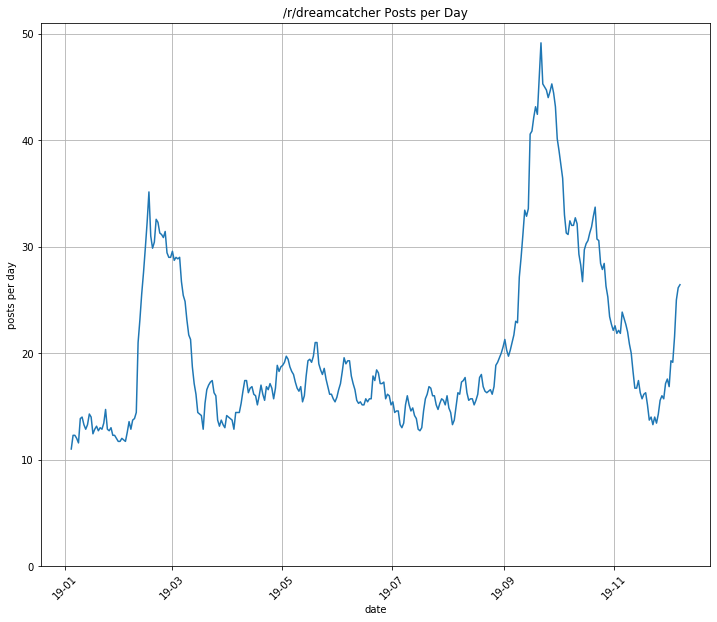

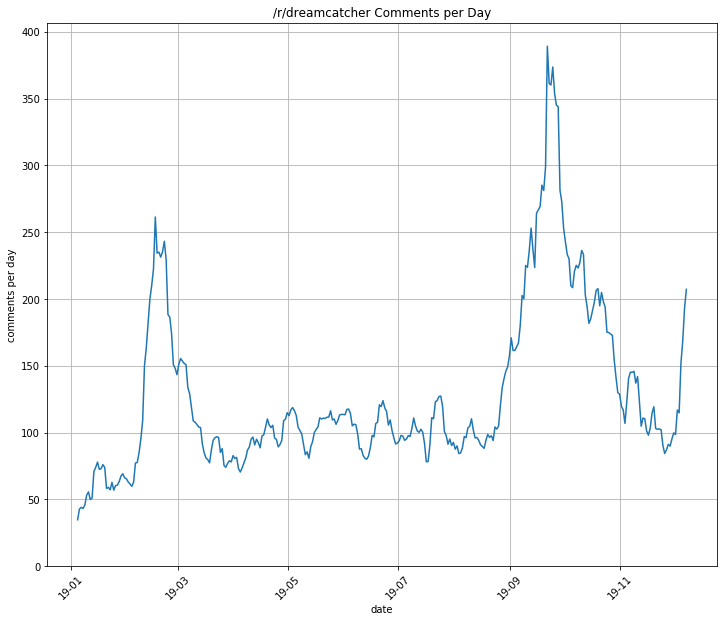

In [9]:
kernel_size = 7

# sort posts by time stamp
chron_posts = SortedDict()

for key, post in posts.items():
    chron_posts[post.ts] = post
    
    
# posts per day
ts_begin = start_epoch
ts_end = kernel_size * secs_in_day + ts_begin # days after ts_begin

post_freq_ts = []
post_freq = []
while ts_end < end_epoch:
    it = chron_posts.irange(ts_begin, ts_end)
    count = 0
    for ts in it:
        count += 1
    ts = (ts_begin + ts_end) / 2
    if count != 0:
        post_freq_ts.append(ts)
        post_freq.append(count)
    ts_begin += secs_in_day
    ts_end += secs_in_day
    
dates = np.array([datetime.datetime.fromtimestamp(ts) for ts in post_freq_ts])
post_freq = np.array(post_freq) / kernel_size

if len(post_freq) > 0:
    plt.figure(figsize=(12,10))
    plt.xticks(rotation=45)
    ax = plt.gca()
    xfmt = md.DateFormatter('%y-%m')
    ax.xaxis.set_major_formatter(xfmt)
    plt.plot(dates, post_freq)
    plt.ylim(bottom=0)
    plt.xlabel('date')
    plt.ylabel('posts per day')
    plt.title('/r/%s Posts per Day' % (sub))
    plt.grid(b=True, which='both', axis='both')

# comments per day
chron_comments = SortedDict()
for key, post in posts.items():
    for comment in post.comments:
        chron_comments[comment.ts] = comment

ts_begin = start_epoch
ts_end = kernel_size * secs_in_day + ts_begin # days after ts_begin

comment_freq_ts = []
comment_freq = []
while ts_end < end_epoch:
    it = chron_comments.irange(ts_begin, ts_end)
    count = 0
    for ts in it:
        count += 1
    ts = (ts_begin + ts_end) / 2
    if count != 0:
        comment_freq_ts.append(ts)
        comment_freq.append(count)
    ts_begin += secs_in_day
    ts_end += secs_in_day
    
dates = np.array([datetime.datetime.fromtimestamp(ts) for ts in comment_freq_ts])
comment_freq = np.array(comment_freq) / kernel_size

if len(comment_freq) > 0:
    plt.figure(figsize=(12,10))
    plt.xticks(rotation=45)
    ax = plt.gca()
    xfmt = md.DateFormatter('%y-%m')
    ax.xaxis.set_major_formatter(xfmt)
    plt.plot(dates, comment_freq)
    plt.ylim(bottom=0)
    plt.xlabel('date')
    plt.ylabel('comments per day')
    plt.title('/r/%s Comments per Day' % (sub))
    plt.grid(b=True, which='both', axis='both')

plt.show()

In [10]:
# Make Score Adjustments

all_ts = np.zeros((len(chron_posts)))
all_scores = np.zeros((len(chron_posts)))

for i, ts in enumerate(chron_posts):
    all_ts[i] = ts - start_epoch
    all_scores[i] = chron_posts[ts].score
    
all_comment_ts = np.zeros((len(chron_comments)))
all_comment_scores = np.zeros((len(chron_comments)))

for i, ts in enumerate(chron_comments):
    all_comment_ts[i] = ts - start_epoch
    all_comment_scores[i] = chron_comments[ts].score
        
post_slope, post_int = np.polyfit(all_ts, all_scores, 1)
comment_slope, comment_int = np.polyfit(all_comment_ts, all_comment_scores, 1)

def calc_adj(ts, score):
    frac_time = (ts - start_epoch) / (end_epoch - start_epoch)
    scalar = score / (frac_time*(end_epoch-start_epoch)*post_slope+post_int)
    adj_score = (post_int+(end_epoch-start_epoch)*post_slope) * scalar
    return float(adj_score)
def calc_comment_adj(ts, score):
    frac_time = (ts - start_epoch) / (end_epoch - start_epoch)
    scalar = score / (frac_time*(end_epoch-start_epoch)*comment_slope+comment_int)
    adj_score = (comment_int+(end_epoch-start_epoch)*comment_slope) * scalar
    return float(adj_score)

### Average Post and Comment Scores

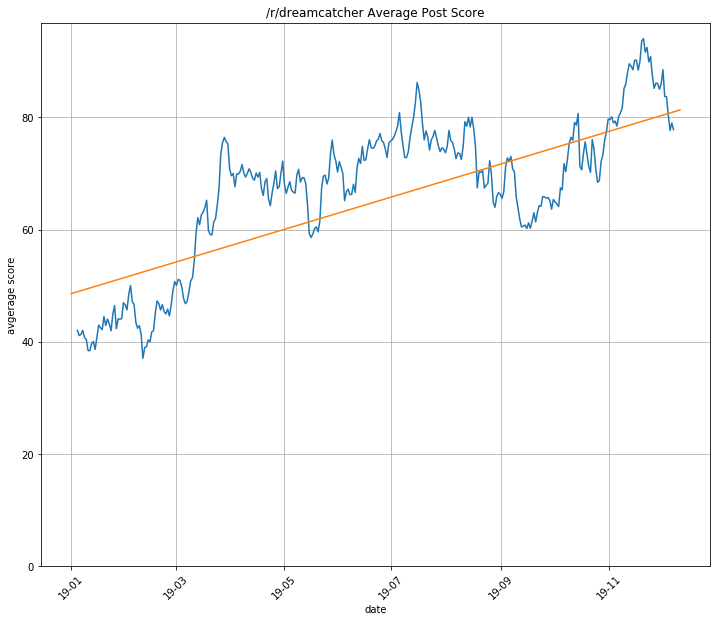

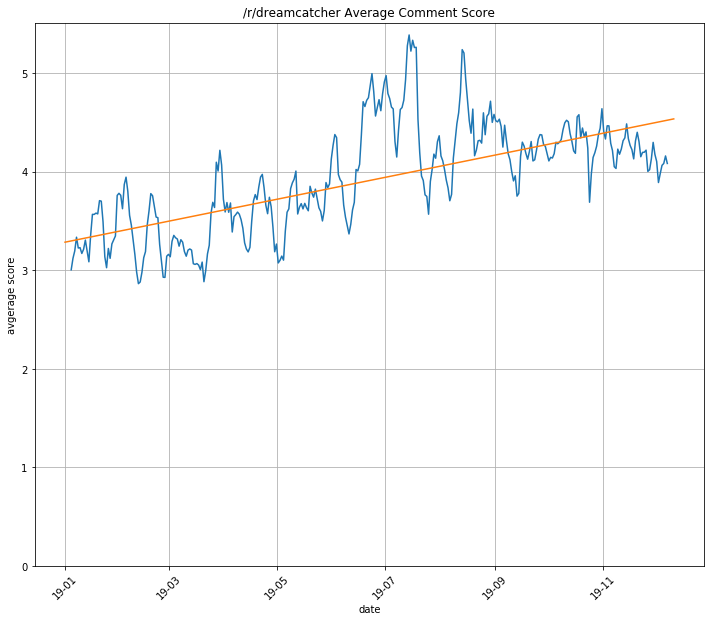

In [11]:
kernel_size = 7

# sort posts by time stamp
chron_posts = SortedDict()

for key, post in posts.items():
    chron_posts[post.ts] = post
    
    
# average post score
ts_begin = start_epoch
ts_end = kernel_size * secs_in_day + ts_begin # days after ts_begin

post_avg_score_ts = []
post_avg_score = []
while ts_end < end_epoch:
    it = chron_posts.irange(ts_begin, ts_end)
    total_score = 0
    count = 0
    for ts in it:
        total_score += chron_posts[ts].score
        count += 1
    ts = (ts_begin + ts_end) / 2
    if count != 0:
        post_avg_score_ts.append(ts)
        post_avg_score.append(total_score / count)
    ts_begin += secs_in_day
    ts_end += secs_in_day
    
dates = np.array([datetime.datetime.fromtimestamp(ts) for ts in post_freq_ts])

plt.figure(figsize=(12,10))
plt.xticks(rotation=45)
ax = plt.gca()
xfmt = md.DateFormatter('%y-%m')
ax.xaxis.set_major_formatter(xfmt)
plt.plot(dates, post_avg_score)
plt.plot([datetime.datetime.fromtimestamp(ts) for ts in [start_epoch, end_epoch]],
         [post_int, post_int+post_slope*(end_epoch-start_epoch)])
plt.ylim(bottom=0)
plt.xlabel('date')
plt.ylabel('avgerage score')
plt.title('/r/%s Average Post Score' % (sub))
plt.grid(b=True, which='both', axis='both')

# average comment score
ts_begin = start_epoch
ts_end = kernel_size * secs_in_day + ts_begin # days after ts_begin

comment_avg_score_ts = []
comment_avg_score = []
while ts_end < end_epoch:
    it = chron_comments.irange(ts_begin, ts_end)
    total_adj_comment_score = 0
    count = 0
    for ts in it:
        total_adj_comment_score += chron_comments[ts].score
        count += 1
    ts = (ts_begin + ts_end) / 2
    if count != 0:
        comment_avg_score_ts.append(ts)
        comment_avg_score.append(total_adj_comment_score / count)
    ts_begin += secs_in_day
    ts_end += secs_in_day
    
dates = np.array([datetime.datetime.fromtimestamp(ts) for ts in comment_avg_score_ts])

plt.figure(figsize=(12,10))
plt.xticks(rotation=45)
ax = plt.gca()
xfmt = md.DateFormatter('%y-%m')
ax.xaxis.set_major_formatter(xfmt)
plt.plot(dates, comment_avg_score)
plt.plot([datetime.datetime.fromtimestamp(ts) for ts in [start_epoch, end_epoch]],
         [comment_int, comment_int+comment_slope*(end_epoch-start_epoch)])
plt.ylim(bottom=0)
plt.xlabel('date')
plt.ylabel('avgerage score')
plt.title('/r/%s Average Comment Score' % (sub))
plt.grid(b=True, which='both', axis='both')

plt.show()

### Average Adjusted Post and Comment Scores

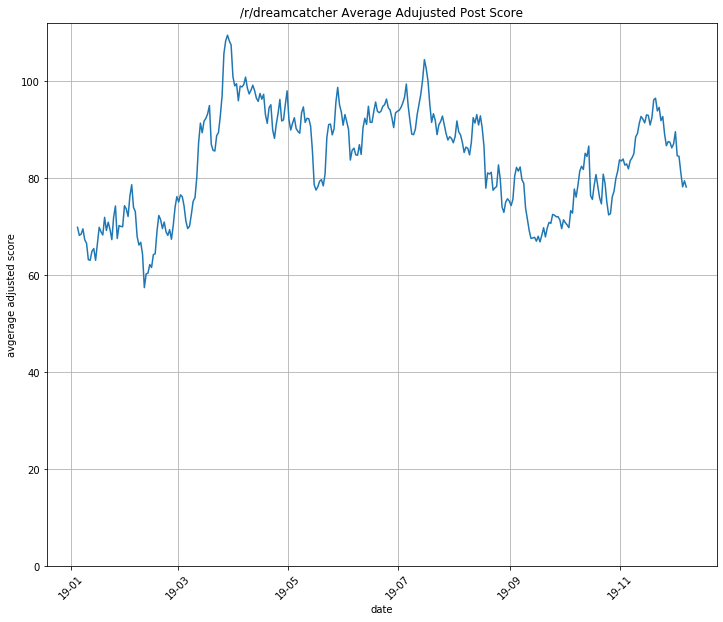

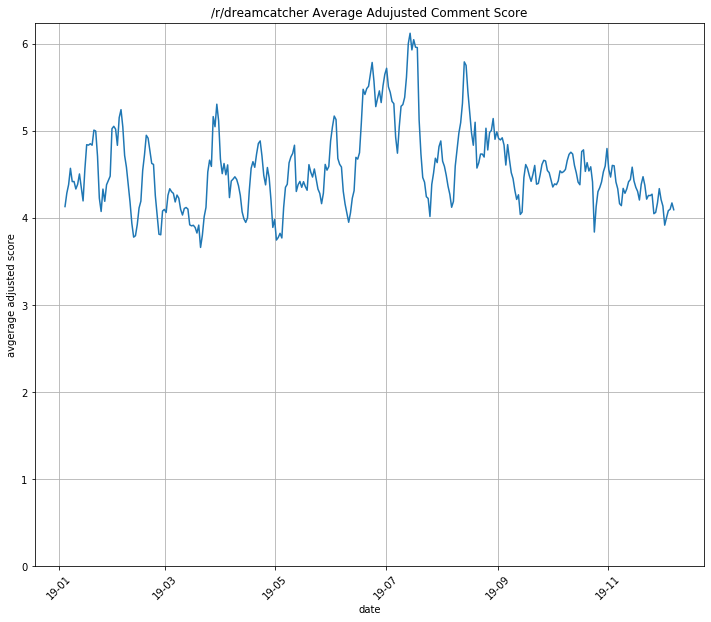

In [12]:
# average post score
ts_begin = start_epoch
ts_end = kernel_size * secs_in_day + ts_begin # days after ts_begin

post_avg_adj_score_ts = []
post_avg_adj_score = []
while ts_end < end_epoch:
    it = chron_posts.irange(ts_begin, ts_end)
    total_adj_score = 0
    count = 0
    for ts in it:
        total_adj_score += calc_adj(ts, chron_posts[ts].score)
        count += 1
    ts = (ts_begin + ts_end) / 2
    if count != 0:
        post_avg_adj_score_ts.append(ts)
        post_avg_adj_score.append(total_adj_score / count)
    ts_begin += secs_in_day
    ts_end += secs_in_day
    
dates = np.array([datetime.datetime.fromtimestamp(ts) for ts in post_avg_score_ts])

plt.figure(figsize=(12,10))
plt.xticks(rotation=45)
ax = plt.gca()
xfmt = md.DateFormatter('%y-%m')
ax.xaxis.set_major_formatter(xfmt)
plt.plot(dates, post_avg_adj_score)
plt.ylim(bottom=0)
plt.xlabel('date')
plt.ylabel('avgerage adjusted score')
plt.title('/r/%s Average Adujusted Post Score' % (sub))
plt.grid(b=True, which='both', axis='both')

# average comment score
ts_begin = start_epoch
ts_end = kernel_size * secs_in_day + ts_begin # days after ts_begin

comment_avg_score_ts = []
comment_avg_score = []
while ts_end < end_epoch:
    it = chron_comments.irange(ts_begin, ts_end)
    total_adj_comment_score = 0
    count = 0
    for ts in it:
        total_adj_comment_score += calc_comment_adj(ts, chron_comments[ts].score)
        count += 1
    ts = (ts_begin + ts_end) / 2
    if count != 0:
        comment_avg_score_ts.append(ts)
        comment_avg_score.append(total_adj_comment_score / count)
    ts_begin += secs_in_day
    ts_end += secs_in_day
    
dates = np.array([datetime.datetime.fromtimestamp(ts) for ts in comment_avg_score_ts])

plt.figure(figsize=(12,10))
plt.xticks(rotation=45)
ax = plt.gca()
xfmt = md.DateFormatter('%y-%m')
ax.xaxis.set_major_formatter(xfmt)
plt.plot(dates, comment_avg_score)
plt.ylim(bottom=0)
plt.xlabel('date')
plt.ylabel('avgerage adjusted score')
plt.title('/r/%s Average Adujusted Comment Score' % (sub))
plt.grid(b=True, which='both', axis='both')

plt.show()

## Leaderboards

### Top Posts

In [13]:
adj_scores = np.zeros((len(posts)), dtype=float)
for i, (key, post) in enumerate(posts.items()):
    ts = int(post.ts)
    adj_scores[i] = calc_adj(ts, post.score)

top_idx = (-adj_scores).argsort()[:10]

posts_list = list(posts)
for i, idx in enumerate(top_idx):
    post = posts[posts_list[idx]]
    ts = int(post.ts)
    ts_str = datetime.datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')
    print('top post #%d' % (i+1))
    print('title:          %s' % (post.title))
    print('author:         %s' % (post.author))
    print('time:           %s' % (ts_str))
    print('score:          %d' % (post.score))
    print('adjusted score: %f' % (calc_adj(post.ts, post.score)))
    print('comments:       %d' % (len(post.comments)))
    print('permalink:      https://www.reddit.com%s' % (post.permalink))
    print()

top post #1
title:          Dreamcatcher - 'Deja Vu' MV
author:         nat1withadv
time:           2019-09-18 09:00:09
score:          502
adjusted score: 556.721774
comments:       100
permalink:      https://www.reddit.comhttps://www.youtube.com/watch?v=W761DtH1oRg

top post #2
title:          Dreamcatcher - 'PIRI' MV
author:         SpideyCyclist
time:           2019-02-13 09:01:13
score:          340
adjusted score: 524.836733
comments:       81
permalink:      https://www.reddit.comhttps://www.youtube.com/watch?v=Pq_mbTSR-a0

top post #3
title:          I think it's safe to say that maknae is all grown up
author:         vagabond2787
time:           2019-10-21 08:10:37
score:          362
adjusted score: 384.993131
comments:       22
permalink:      https://www.reddit.comhttps://i.redd.it/gnlwj1i8rut31.jpg

top post #4
title:          PIRI Practice Upvote GIF
author:         nat1withadv
time:           2019-02-18 13:58:33
score:          244
adjusted score: 373.138874
comments:  

### Top Comments

In [14]:
all_comments = []
comment_ts2post_ts = None
for i, (key, post) in enumerate(posts.items()):
    ts = int(post.ts)
    for comment in post.comments:
        all_comments.append(comment)
#         if comment.ts not in comment_ts2post_ts:
#             comment_ts2post_ts[comment.ts] = ts

adj_scores = np.zeros((len(all_comments)), dtype=float)
for i, comment in enumerate(all_comments):
    ts = int(comment.ts)
    adj_scores[i] = calc_comment_adj(ts, comment.score)
    
top_idx = (-adj_scores).argsort()[:10]

for i, idx in enumerate(top_idx):
    comment = all_comments[idx]
    body = comment.body.replace('\n', ' ')
    body = (body[:97] + '...') if len(body) > 97 else body
    ts = int(comment.ts)
    ts_str = datetime.datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')
    print('top comment #%d' % (i+1))
    print('comment:        %s' % (body))
    print('author:         %s' % (comment.author))
    print('time:           %s' % (ts_str))
    print('score:          %d' % (comment.score))
    print('adjusted score: %f' % (adj_scores[idx]))
    print('permalink:      https://www.reddit.com%s' % (comment.permalink))
    print()

top comment #1
comment:        JiU was envious of other groups because they had their official fanclub fanmeetings. Since Dreamc...
author:         SpideyCyclist
time:           2019-10-20 20:30:25
score:          76
adjusted score: 79.272124
permalink:      https://www.reddit.com/r/dreamcatcher/comments/dkpcb6/jiu_cried_because_she_felt_very_grateful_that/f4ifu6q/

top comment #2
comment:        Thank you for the great performance today, girls. Congratulations to Everglow for winning 'The Sh...
author:         SpideyCyclist
time:           2019-09-24 10:43:54
score:          65
adjusted score: 69.328094
permalink:      https://www.reddit.com/r/dreamcatcher/comments/d8la3j/dreamcatcher_is_2nd_place_on_the_show_today_thank/f1b3a3o/

top comment #3
comment:        Somewhere in Korea, Siyeon wakes up in a cold sweat.
author:         internet0jesus
time:           2019-03-02 07:57:13
score:          51
adjusted score: 66.021664
permalink:      https://www.reddit.com/r/dreamcatcher/comments

### Top Posters

In [15]:
users = OrderedDict()
for i, (key, post) in enumerate(posts.items()):
    ts = int(post.ts)
    if post.author == None:
        continue
    if post.author not in users:
        users[post.author] = {}
        users[post.author]['score'] = 0
        users[post.author]['adj_score'] = 0
        users[post.author]['posts'] = 0
        users[post.author]['comment_score'] = 0
        users[post.author]['adj_comment_score'] = 0
        users[post.author]['comments'] = 0
    users[post.author]['score'] += post.score
    users[post.author]['adj_score'] += calc_adj(ts, post.score)
    users[post.author]['posts'] += 1
    for comment in post.comments:
        if comment.author not in users:
            users[comment.author] = {}
            users[comment.author]['score'] = 0
            users[comment.author]['adj_score'] = 0
            users[comment.author]['posts'] = 0
            users[comment.author]['comment_score'] = 0
            users[comment.author]['adj_comment_score'] = 0
            users[comment.author]['comments'] = 0
        users[comment.author]['comment_score'] += comment.score
        users[comment.author]['adj_comment_score'] += calc_comment_adj(comment.ts, comment.score)
        users[comment.author]['comments'] += 1

In [16]:
sorted_posters = OrderedDict(sorted(users.items(), key=lambda x: x[1]['adj_score'], reverse=True))

for i, key in enumerate(sorted_posters):
    if i >= 10:
        break
    print('top poster #%d' % (i+1))
    print('user:                  %s' % (key))
    print('total number of posts: %d' % (sorted_posters[key]['posts']))
    print('total score:           %d' % (sorted_posters[key]['score']))
    print('total adjusted score:  %f' % (sorted_posters[key]['adj_score']))
    print()

top poster #1
user:                  SpideyCyclist
total number of posts: 2343
total score:           149499
total adjusted score:  184848.928276

top poster #2
user:                  MetallicCats
total number of posts: 945
total score:           102019
total adjusted score:  119907.466895

top poster #3
user:                  nat1withadv
total number of posts: 629
total score:           44173
total adjusted score:  50032.318465

top poster #4
user:                  Frostbite522
total number of posts: 286
total score:           25664
total adjusted score:  35850.886406

top poster #5
user:                  Xerachiel
total number of posts: 211
total score:           14863
total adjusted score:  17380.969772

top poster #6
user:                  Yoohyeon_dimple
total number of posts: 117
total score:           10632
total adjusted score:  13708.209346

top poster #7
user:                  vagabond2787
total number of posts: 130
total score:           9518
total adjusted score:  12856.074

## Top Commenters

In [17]:
sorted_commenters = OrderedDict(sorted(users.items(), key=lambda x: x[1]['adj_comment_score'], reverse=True))

for i, key in enumerate(sorted_commenters):
    if i >= 10:
        break
    print('top commenter #%d' % (i+1))
    print('user:                          %s' % (key))
    print('total number of comments:      %d' % (sorted_commenters[key]['comments']))
    print('total comment score:           %d' % (sorted_commenters[key]['comment_score']))
    print('total adjusted comment score:  %f' % (sorted_commenters[key]['adj_comment_score']))
    print()

top commenter #1
user:                          SpideyCyclist
total number of comments:      6744
total comment score:           31219
total adjusted comment score:  35237.586135

top commenter #2
user:                          MetallicCats
total number of comments:      4821
total comment score:           25693
total adjusted comment score:  28758.391847

top commenter #3
user:                          nat1withadv
total number of comments:      3009
total comment score:           13089
total adjusted comment score:  14495.955507

top commenter #4
user:                          internet0jesus
total number of comments:      2248
total comment score:           10454
total adjusted comment score:  12344.513219

top commenter #5
user:                          Xerachiel
total number of comments:      2215
total comment score:           8644
total adjusted comment score:  9464.929449

top commenter #6
user:                          ipwnmice
total number of comments:      1351
total comment s

## Top Average Users

In [18]:
temp = OrderedDict()
for user in users:
    if user not in temp:
        temp[user] = {}
        
    if users[user]['posts'] == 0:
        temp[user]['avg_adj_score'] = 0;
    else:
        temp[user]['avg_adj_score'] = users[user]['adj_score'] / users[user]['posts']
        
    if users[user]['comments'] == 0:
        temp[user]['avg_adj_comment_score'] = 0;
    else:
        temp[user]['avg_adj_comment_score'] = users[user]['adj_comment_score'] / users[user]['comments']


In [19]:
sorted_avg_posters = OrderedDict(sorted(temp.items(), key=lambda x: x[1]['avg_adj_score'], reverse=True))

i = 0;
for key in sorted_avg_posters:
    if i >= 10:
        break
    if users[key]['posts'] < 10:
        continue
    print('top avg poster #%d' % (i+1))
    print('user:                  %s' % (key))
    print('avg adjusted score:    %f' % (sorted_avg_posters[key]['avg_adj_score']))
    print('total number of posts: %d' % (users[key]['posts']))
    print('total score:           %d' % (users[key]['score']))
    print('total adjusted score:  %f' % (users[key]['adj_score']))
    print()
    i += 1

top avg poster #1
user:                  GamerYoohyeon
avg adjusted score:    159.594059
total number of posts: 46
total score:           5150
total adjusted score:  7341.326703

top avg poster #2
user:                  myblindy
avg adjusted score:    151.110524
total number of posts: 43
total score:           4841
total adjusted score:  6497.752549

top avg poster #3
user:                  boredstephanie
avg adjusted score:    141.983047
total number of posts: 43
total score:           5481
total adjusted score:  6105.271021

top avg poster #4
user:                  laoska73
avg adjusted score:    136.876882
total number of posts: 16
total score:           1923
total adjusted score:  2190.030108

top avg poster #5
user:                  Mister_StealYoGirl
avg adjusted score:    132.112803
total number of posts: 15
total score:           1858
total adjusted score:  1981.692044

top avg poster #6
user:                  MetallicCats
avg adjusted score:    126.886208
total number of posts

In [20]:
sorted_avg_commenters = OrderedDict(sorted(temp.items(), key=lambda x: x[1]['avg_adj_comment_score'], reverse=True))

i = 0
for key in sorted_avg_commenters:
    if i >= 10:
        break
    if users[key]['comments'] < 30:
        continue
    print('top avg commenter #%d' % (i+1))
    print('user:                         %s' % (key))
    print('avg adjusted comment score:   %f' % (sorted_avg_commenters[key]['avg_adj_comment_score']))
    print('total number of comments:     %d' % (users[key]['comments']))
    print('total comment score:          %d' % (users[key]['comment_score']))
    print('total adjusted comment score: %f' % (users[key]['adj_comment_score']))
    print()
    i += 1

top avg commenter #1
user:                         MiMcMiM
avg adjusted comment score:   7.146890
total number of comments:     181
total comment score:          1160
total adjusted comment score: 1293.587029

top avg commenter #2
user:                         Ashe171
avg adjusted comment score:   6.757461
total number of comments:     42
total comment score:          259
total adjusted comment score: 283.813368

top avg commenter #3
user:                         carrieaboo
avg adjusted comment score:   6.738533
total number of comments:     74
total comment score:          490
total adjusted comment score: 498.651435

top avg commenter #4
user:                         sevenwonderz
avg adjusted comment score:   6.531151
total number of comments:     30
total comment score:          189
total adjusted comment score: 195.934522

top avg commenter #5
user:                         markus135
avg adjusted comment score:   6.462268
total number of comments:     33
total comment score:        

# Posts and Comments with Reddit awards

## Posts

In [75]:
print("Platinums:")
for post in posts.items():
    if 'gid_3' in post[1].gildings:
        print(f"https://www.reddit.com{post[1].permalink}")
        
print("\nGolds:")
for post in posts.items():
    if 'gid_2' in post[1].gildings:
        print(f"https://www.reddit.com{post[1].permalink}")
        
print("\nSilvers:")
for post in posts.items():
    if 'gid_1' in post[1].gildings:
        print(f"https://www.reddit.com{post[1].permalink}")

Platinums:
https://redd.it/c923qp    
https://redd.it/aq4r6c    

Golds:
https://redd.it/dtyqp1    
https://redd.it/dpcsme    
https://redd.it/dejl3s    
https://redd.it/d8xagh    
https://redd.it/cz32hh    
https://redd.it/cmowjn    
https://redd.it/bso5o0    
https://redd.it/bsh40o    
https://redd.it/bl3eho    
https://redd.it/ashoxx    
https://redd.it/ar0erl    

Silvers:
https://redd.it/dsva1n    
https://redd.it/cozdq6    
https://redd.it/c9uval    
https://redd.it/bt407u    
https://redd.it/b72e5u    
https://redd.it/ajn4pg    


## Comments

In [77]:
print("Platinums:")
for comment in all_comments:
    if 'gid_3' in comment.gildings:
        print(f"https://www.reddit.com{comment.permalink}/?context=10000")
        
print("\nGolds:")
for comment in all_comments:
    if 'gid_2' in comment.gildings:
        print(f"https://www.reddit.com{comment.permalink}/?context=10000")
        
print("\nSilvers:")
for comment in all_comments:
    if 'gid_1' in comment.gildings:
        print(f"https://www.reddit.com{comment.permalink}/?context=10000")

Platinums:

Golds:


AttributeError: 'Comment' object has no attribute 'permalink'

# Submission flair distribution

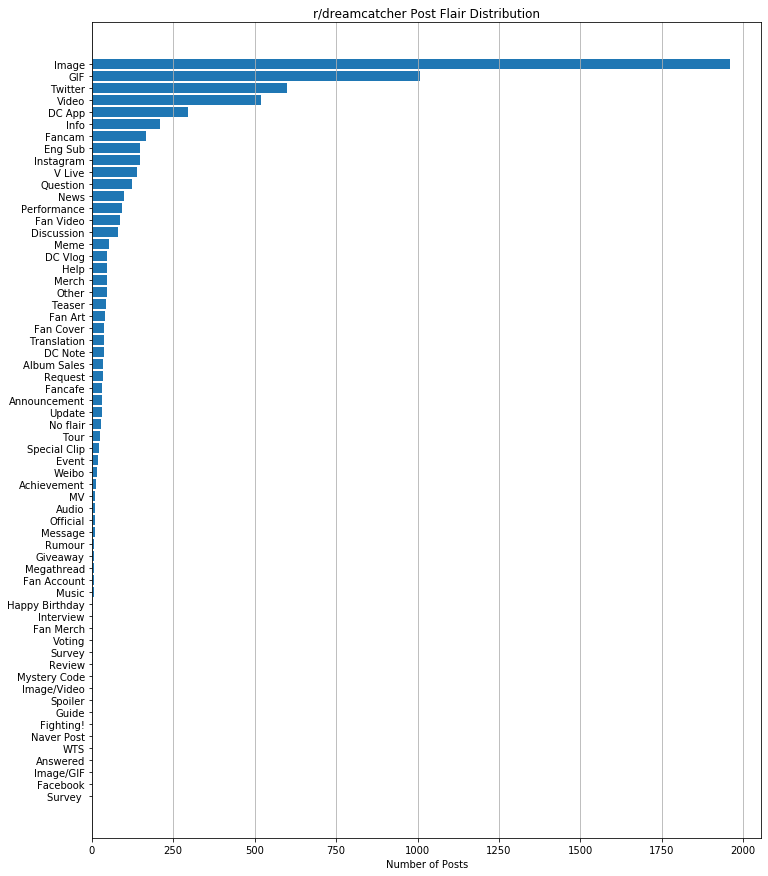

[('Image', 1958), ('GIF', 1007), ('Twitter', 598), ('Video', 520), ('DC App', 296), ('Info', 208), ('Fancam', 167), ('Eng Sub', 149), ('Instagram', 147), ('V Live', 138), ('Question', 123), ('News', 98), ('Performance', 92), ('Fan Video', 88), ('Discussion', 81), ('Meme', 52), ('Help', 48), ('DC Vlog', 48), ('Merch', 47), ('Other', 46), ('Teaser', 42), ('Fan Art', 39), ('Fan Cover', 37), ('DC Note', 36), ('Translation', 36), ('Request', 34), ('Album Sales', 34), ('Announcement', 31), ('Fancafe', 31), ('Update', 30), ('No flair', 28), ('Tour', 26), ('Special Clip', 21), ('Event', 20), ('Weibo', 15), ('Achievement', 13), ('MV', 11), ('Message', 10), ('Official', 10), ('Audio', 10), ('Rumour', 8), ('Giveaway', 7), ('Music', 6), ('Fan Account', 6), ('Megathread', 6), ('Fan Merch', 5), ('Interview', 5), ('Happy Birthday', 5), ('Review', 4), ('Survey', 4), ('Voting', 4), ('Spoiler', 3), ('Image/Video', 3), ('Mystery Code', 3), ('WTS', 2), ('Naver Post', 2), ('Fighting!', 2), ('Guide', 2), ('

In [214]:
flairs = {}
for post in posts.items():
    if post[1].author is None or post[1].selftext == '[removed]':
        continue
    if post[1].link_flair is None:
        if 'No flair' not in flairs:
            flairs['No flair'] = 0
        flairs['No flair'] += 1
    else:
        if post[1].link_flair not in flairs:
            flairs[post[1].link_flair] = 0
        flairs[post[1].link_flair] += 1

flairs_chart = []
nums_chart = []
for flair,num in sorted(flairs.items(), key=lambda x: x[1]):
    flairs_chart.append(flair)
    nums_chart.append(num)

plt.figure(figsize=(12,15))
plt.barh(flairs_chart, nums_chart)
plt.grid(b=True, axis='x')
plt.title(f"r/{sub} Post Flair Distribution")
plt.xlabel("Number of Posts")
plt.show()

print(sorted(flairs.items(), key=lambda x: -x[1]))

# Member mention distribution

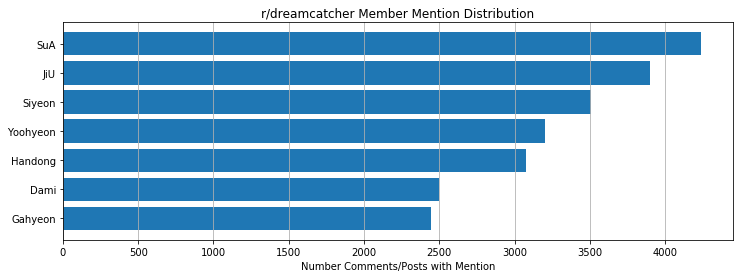

[('SuA', 4236), ('JiU', 3901), ('Siyeon', 3505), ('Yoohyeon', 3204), ('Handong', 3073), ('Dami', 2501), ('Gahyeon', 2444)]


In [154]:
member_names = {
    'JiU': ['jiu', 'minji', 'lily', 'jyu', '지유', '민지'],
    'SuA': ['sua', 'bora', 'alice', 'swa', '수아', '보라'],
    'Siyeon': ['siyeon', 'monica', 'singnie', '시연'],
    'Handong': ['handong', 'della', 'dong', 'dongie', '한동', '韩东', '韓東'],
    'Yoohyeon': ['yoohyeon', 'rachel', '유현'],
    'Dami': ['dami', 'yoobin', 'yubin', 'emma', '다미', '유빈'],
    'Gahyeon': ['gahyeon', 'lucy', 'gahyeonnie', 'gahyeonie', '가현']
}

member_mentions = {}

for comment in all_comments:
    for member in member_names:
        if member not in member_mentions:
            member_mentions[member] = 0
        for nickname in member_names[member]:
            if -1 != comment.body.casefold().find(nickname.casefold()):
                member_mentions[member] += 1
                break
                
for post in posts.items():
    for member in member_names:
        if member not in member_mentions:
            member_mentions[member] = 0
        for nickname in member_names[member]:
            if -1 != post[1].title.casefold().find(nickname.casefold()):
                member_mentions[member] += 1
                break
            if -1 != post[1].selftext.casefold().find(nickname.casefold()):
                member_mentions[member] += 1
                break

members_chart = []
nums_chart = []
for member,num in sorted(member_mentions.items(), key=lambda x: x[1]):
    members_chart.append(member)
    nums_chart.append(num)

plt.figure(figsize=(12,4))
plt.barh(members_chart, nums_chart)
plt.grid(b=True, axis='x')
plt.title(f"r/{sub} Member Mention Distribution")
plt.xlabel("Number Comments/Posts with Mention")
plt.show()

print(sorted(member_mentions.items(), key=lambda x: -x[1]))

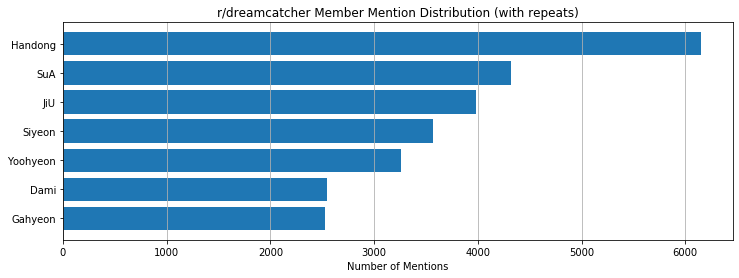

[('Handong', 6148), ('SuA', 4323), ('JiU', 3979), ('Siyeon', 3566), ('Yoohyeon', 3257), ('Dami', 2545), ('Gahyeon', 2529)]


In [155]:
member_mentions = {}

for comment in all_comments:
    for member in member_names:
        if member not in member_mentions:
            member_mentions[member] = 0
        for nickname in member_names[member]:
            if -1 != comment.body.casefold().find(nickname.casefold()):
                member_mentions[member] += 1
                
for post in posts.items():
    for member in member_names:
        if member not in member_mentions:
            member_mentions[member] = 0
        for nickname in member_names[member]:
            if -1 != post[1].title.casefold().find(nickname.casefold()):
                member_mentions[member] += 1
            if -1 != post[1].selftext.casefold().find(nickname.casefold()):
                member_mentions[member] += 1

members_chart = []
nums_chart = []
for member,num in sorted(member_mentions.items(), key=lambda x: x[1]):
    members_chart.append(member)
    nums_chart.append(num)

plt.figure(figsize=(12,4))
plt.barh(members_chart, nums_chart)
plt.grid(b=True, axis='x')
plt.title(f"r/{sub} Member Mention Distribution (with repeats)")
plt.xlabel("Number of Mentions")
plt.show()

print(sorted(member_mentions.items(), key=lambda x: -x[1]))

# Mentions of r/dreamcatcher

In [179]:
rkpop_mentions = api_ps_praw.search_comments(after=start_epoch,
                                  before=end_epoch,
                                  subreddit='kpop',
                                  q=f'"r/{sub}"',
                                  limit=max_posts)
rkpop_count = 0
for k in rkpop_mentions:
    rkpop_count += 1

reddit_mentions = api_ps_praw.search_comments(after=start_epoch,
                                  before=end_epoch,
                                  subreddit=f'!{sub}',
                                  q=f'"r/{sub}"',
                                  limit=max_posts)
reddit_count = 0
reddit_mentions_dict = {}
for k in reddit_mentions:
    if k.subreddit not in reddit_mentions_dict:
        reddit_mentions_dict[k.subreddit] = 0
    reddit_mentions_dict[k.subreddit] += 1
    reddit_count += 1

print(f'Mentions of r/{sub} in r/kpop: {rkpop_count}')
print(f'Mentions of r/{sub} on reddit: {reddit_count}')
print(sorted(reddit_mentions_dict.items(), key=lambda x: -x[1]))

Mentions of r/dreamcatcher in r/kpop: 23
Mentions of r/dreamcatcher on reddit: 106
[(Subreddit(display_name='asiangirlsbeingcute'), 32), (Subreddit(display_name='kpop'), 23), (Subreddit(display_name='kpophelp'), 15), (Subreddit(display_name='kpics'), 10), (Subreddit(display_name='Kings_Raid'), 5), (Subreddit(display_name='memecatcher'), 4), (Subreddit(display_name='DreamcatcherUSA'), 4), (Subreddit(display_name='kpopforsale'), 2), (Subreddit(display_name='SuddenlyGay'), 2), (Subreddit(display_name='synthrecipes'), 1), (Subreddit(display_name='crystalclear'), 1), (Subreddit(display_name='music_lists'), 1), (Subreddit(display_name='Everglow'), 1), (Subreddit(display_name='twice'), 1), (Subreddit(display_name='leagueoflegends'), 1), (Subreddit(display_name='SuddenlyLesbian'), 1), (Subreddit(display_name='findareddit'), 1), (Subreddit(display_name='kpoppers'), 1)]


# Top Gfycat and Streamable links

In [203]:
regex = r'(streamable\.com\/[a-zA-Z0-9]+)|(gfycat\.com\/\w+)'

gfy_streamable_links = {}

for comment in all_comments:
    x = re.search(regex, comment.body, re.IGNORECASE)
    if x is not None:
        if x.group() not in gfy_streamable_links:
            gfy_streamable_links[x.group()] = 0
        gfy_streamable_links[x.group()] += 1
        
for post in posts.items():
    x = re.search(regex, post[1].url, re.IGNORECASE)
    if x is not None:
        if x.group() not in gfy_streamable_links:
            gfy_streamable_links[x.group()] = 0
        gfy_streamable_links[x.group()] += 1
        
    x = re.search(regex, post[1].selftext, re.IGNORECASE)
    if x is not None:
        if x.group() not in gfy_streamable_links:
            gfy_streamable_links[x.group()] = 0
        gfy_streamable_links[x.group()] += 1
        
for link,num in sorted(gfy_streamable_links.items(), key=lambda x: -x[1])[:20]:
    print(f'{num}\thttps://www.{link}')

8	https://www.gfycat.com/vigorousmilkyannashummingbird
5	https://www.gfycat.com/likelyemotionalalaskanmalamute
4	https://www.streamable.com/msmyz
4	https://www.streamable.com/195jg
4	https://www.gfycat.com/spicyvigorousbarbet
4	https://www.gfycat.com/linedacademicarthropods
4	https://www.gfycat.com/parallelgivingalligatorgar
4	https://www.gfycat.com/milkydefensivekouprey
4	https://www.streamable.com/j48ja
4	https://www.streamable.com/fbv6e
3	https://www.gfycat.com/simplecleanicterinewarbler
3	https://www.gfycat.com/tornoddballblackfish
3	https://www.gfycat.com/pointlessdefiantkudu
3	https://www.gfycat.com/shabbypiercingaustraliankelpie
3	https://www.streamable.com/g7ka4
3	https://www.gfycat.com/aggravatingdependablefox
3	https://www.gfycat.com/alertplaingerbil
3	https://www.gfycat.com/onlydimpledcopperbutterfly
3	https://www.streamable.com/oq3ib
3	https://www.streamable.com/yxuf7


# Most used emojis

In [256]:
import emoji

emojis = {}

emojis_list = map(lambda x: ''.join(x.split()), emoji.UNICODE_EMOJI.keys())
r = re.compile('|'.join(re.escape(p) for p in emojis_list))

for comment in all_comments:
    matches = r.findall(comment.body)
    if len(matches) != 0:
        matches = list(dict.fromkeys(matches))
        for emoji in matches:
            if emoji not in emojis:
                emojis[emoji] = 0
            emojis[emoji] += 1

for post in posts.items():
    matches = r.findall(post[1].title)
    if len(matches) != 0:
        matches = list(dict.fromkeys(matches))
        for emoji in matches:
            if emoji not in emojis:
                emojis[emoji] = 0
            emojis[emoji] += 1
            
    matches = r.findall(post[1].selftext)
    if len(matches) != 0:
        matches = list(dict.fromkeys(matches))
        for emoji in matches:
            if emoji not in emojis:
                emojis[emoji] = 0
            emojis[emoji] += 1

print(sorted(emojis.items(), key=lambda x: -x[1]))

[('❤', 602), ('😂', 275), ('👀', 216), ('🤔', 161), ('👍', 138), ('😭', 137), ('😍', 131), ('😊', 104), ('😅', 78), ('👌', 76), ('😉', 75), ('🏻', 75), ('😄', 69), ('💕', 68), ('♥', 67), ('😆', 66), ('🔥', 61), ('🤣', 60), ('😁', 55), ('🐺', 53), ('🥰', 51), ('🐰', 51), ('📷', 50), ('😘', 44), ('🙏', 41), ('😎', 40), ('🤘', 40), ('🐶', 37), ('💙', 35), ('🤗', 30), ('✨', 29), ('🌙', 29), ('✔', 29), ('☺', 27), ('🥺', 26), ('💜', 26), ('❣', 26), ('👋', 23), ('✌', 23), ('🎉', 23), ('🎁', 23), ('🍀', 22), ('🎂', 22), ('👏', 22), ('🎶', 21), ('🤩', 21), ('▶', 21), ('😔', 20), ('😢', 18), ('💋', 18), ('🐼', 18), ('💪', 18), ('🌑', 16), ('🖤', 15), ('🙌', 15), ('😋', 15), ('😮', 14), ('😥', 14), ('😃', 14), ('💀', 13), ('🐘', 13), ('🐱', 13), ('🙂', 13), ('🤟', 13), ('😱', 12), ('😤', 12), ('💖', 12), ('👊', 12), ('😏', 12), ('☀', 11), ('😴', 11), ('♀', 11), ('😀', 11), ('💗', 11), ('😜', 11), ('🥴', 11), ('🏼', 11), ('🌞', 11), ('🍒', 10), ('😚', 10), ('🤞', 10), ('💛', 10), ('💞', 9), ('🥳', 9), ('🤭', 9), ('😩', 9), ('‼', 9), ('🙃', 9), ('™', 9), ('😲', 8), ('😣', 8),

# Unique contributors

## Total unique contributors

In [264]:
authors = set()
for comment in all_comments:
    try:
        authors.add(comment.author.name)
    except AttributeError:
        pass
for post in posts.items():
    try:
        authors.add(post[1].author.name)
    except AttributeError:
        pass

print(f'r/{sub} unique contributors: {len(authors)}')

r/dreamcatcher unique contributors: 1503


## Unique contributors per week

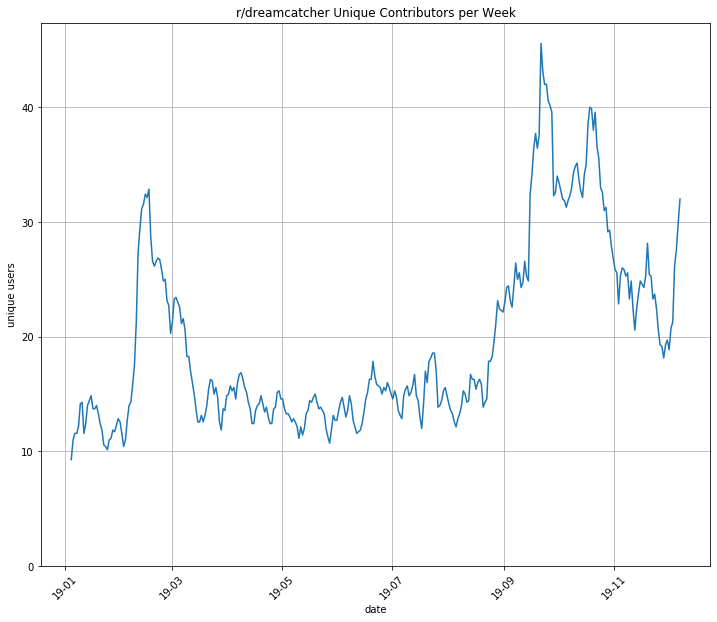

In [279]:
kernel_size = 7

# sort posts and comments by time stamp
chron_posts = SortedDict()
for key, post in posts.items():
    chron_posts[post.ts] = post
    
chron_comments = SortedDict()
for key, post in posts.items():
    for comment in post.comments:
        chron_comments[comment.ts] = comment
    
    
# unique users per week
ts_begin = start_epoch
ts_end = kernel_size * secs_in_day + ts_begin # days after ts_begin

contrib_freq_ts = []
contrib_freq = []
while ts_end < end_epoch:
    count = 0
    authors = set()
    
    # posts
    it = chron_posts.irange(ts_begin, ts_end)
    for ts in it:
        try:
            authors.add(chron_posts[ts].author.name)
        except AttributeError:
            pass
    
    # comments
    it = chron_comments.irange(ts_begin, ts_end)
    for ts in it:
        try:
            authors.add(chron_comments[ts].author.name)
        except AttributeError:
            pass
        
    count = len(authors)
    ts = (ts_begin + ts_end) / 2
    if count != 0:
        contrib_freq_ts.append(ts)
        contrib_freq.append(count)
    ts_begin += secs_in_day
    ts_end += secs_in_day
    
dates = np.array([datetime.datetime.fromtimestamp(ts) for ts in contrib_freq_ts])
contrib_freq = np.array(contrib_freq) / kernel_size

if len(post_freq) > 0:
    plt.figure(figsize=(12,10))
    plt.xticks(rotation=45)
    ax = plt.gca()
    xfmt = md.DateFormatter('%y-%m')
    ax.xaxis.set_major_formatter(xfmt)
    plt.plot(dates, contrib_freq)
    plt.ylim(bottom=0)
    plt.xlabel('date')
    plt.ylabel('unique users')
    plt.title(f'r/{sub} Unique Contributors per Week')
    plt.grid(b=True, which='both', axis='both')